In [1]:
import argparse
import os
import shutil
import time
import yaml
import sys
import gdown
import numpy as np
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from monai.config import KeysCollection
from monai.metrics import Cumulative, CumulativeAverage
from monai.networks.nets import milmodel, resnet, MILModel

from sklearn.metrics import cohen_kappa_score
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data.dataloader import default_collate
from torchvision.models.resnet import ResNet50_Weights
import shutil
from pathlib import Path
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter
from monai.utils import set_determinism
import matplotlib.pyplot as plt
import wandb
import math
import logging
from pathlib import Path


from src.model.MIL import MILModel_3D
from src.model.csPCa_model import csPCa_Model
from src.data.data_loader import get_dataloader
from src.utils import save_cspca_checkpoint, get_metrics, setup_logging, save_pirads_checkpoint
from src.train import train_cspca, train_pirads
import SimpleITK as sitk 

import nrrd

from tqdm import tqdm
import pandas as pd
from picai_prep.preprocessing import PreprocessingSettings, Sample
import multiprocessing
import sys
from src.preprocessing.register_and_crop import register_files
from src.preprocessing.prostate_mask import get_segmask
from src.preprocessing.histogram_match import histmatch
from src.preprocessing.generate_heatmap import get_heatmap
import logging
from pathlib import Path
from src.utils import setup_logging
from src.utils import validate_steps
import argparse
import yaml 
from src.data.data_loader import data_transform, list_data_collate
from monai.data import Dataset, load_decathlon_datalist, ITKReader, NumpyReader, PersistentDataset

If you have questions or suggestions, feel free to open an issue at https://github.com/DIAGNijmegen/picai_prep



In [1]:
import subprocess
import sys
from pathlib import Path
import torch
import pytest
import argparse
from src.train.train_pirads import get_attention_scores


In [8]:
batch_size = 2
num_patches = 4

# Sample 0: Target = 3 (Cancer), Sample 1: Target = 0 (PI-RADS 2)
data = torch.randn(batch_size, num_patches, 1, 8, 8)
target = torch.tensor([3.0, 0.0])

# Create heatmaps: Sample 0 has one "hot" patch
heatmap = torch.zeros(batch_size, num_patches, 1, 8, 8)
heatmap[0, 0] = 10.0 # High attention on patch 0 for the first sample
heatmap[0, 3] = 2.0 
heatmap[1, 2] = 5.0  # Should be overridden by PI-RADS 2 logic anyway


In [25]:
def mock_args():
    # Mocking argparse for the device
    args = argparse.Namespace()
    args.device = "cuda" if torch.cuda.is_available() else "cpu"
    return args

In [41]:
num_patches = 10

# Distinct data per patch: [0, 1, 2, 3...]
data = torch.arange(num_patches).view(1, num_patches, 1, 1, 1).float()
target = torch.tensor([3.0])

# Heatmap matches the data indices so we can track the "label"
heatmap = torch.arange(num_patches).view(1, num_patches, 1, 1, 1).float()

att_labels, shuffled_images = get_attention_scores(data, target, heatmap, mock_args)


idx= (shuffled_images[0, :, 0, 0, 0] == 9.0).nonzero(as_tuple=True)[0]
# The attention score at that same index should be the maximum
assert att_labels[0, idx] == att_labels[0].max()

idx = (shuffled_images[0, :, 0, 0, 0] == 0.0).nonzero(as_tuple=True)[0]
# The attention score at that same index should be the maximum
assert att_labels[0, idx] == att_labels[0].min()

idx = (shuffled_images[0, :, 0, 0, 0] == 5.0).nonzero(as_tuple=True)[0]
# The attention score at that same index should be the maximum
assert att_labels[0, idx] == att_labels[0].median()

AssertionError: 

In [2]:
import subprocess
import sys
from pathlib import Path
import torch
import pytest
import argparse
from src.train.train_pirads import get_attention_scores
import monai
from monai.transforms import Transform
from src.data.custom_transforms import NormalizeIntensity_custom

In [3]:
img = torch.zeros((2, 4, 4), dtype=torch.float32)
mask = torch.zeros((1, 4, 4), dtype=torch.float32)

In [4]:
img

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [5]:
img[0, :, :] = 100.0  # Background
img[0, 0, 0] = 10.0   # Masked pixel 1
img[0, 0, 1] = 20.0   # Masked pixel 2

# --- Channel 1 Setup ---
# Inside mask: Values [2, 4]
# Outside mask: Value 50
img[1, :, :] = 50.0   # Background
img[1, 0, 0] = 2.0    # Masked pixel 1
img[1, 0, 1] = 4.0    # Masked pixel 2

# --- Mask Setup ---
# Selects only the top-left two pixels (0,0) and (0,1)
mask[0, 0, 0] = 1
mask[0, 0, 1] = 1


In [ ]:
data = torch.rand(1, 10, 10)
mask = torch.randint(0, 2, (1, 10, 10)).float()
normalizer = NormalizeIntensity_custom(nonzero=False, channel_wise=True)
out = normalizer(data, mask)

In [25]:
masked = data[mask != 0]
mean_ = torch.mean(masked.float())
std_ = torch.std(masked.float(), unbiased=False)

epsilon = 1e-8
normalized_data = (data - mean_) / (std_ + epsilon)

In [23]:
masked

tensor([ 1.4106, -0.1975,  0.3907,  1.2870, -0.7974, -1.2061,  0.7028,  1.2778,
         0.4667, -0.3361, -0.7842, -1.6296, -1.2037,  1.3582, -0.5648, -0.3055,
        -0.3313,  0.0328, -1.0675,  0.6328, -0.2215, -1.3372,  0.5165,  1.9302,
         0.8875,  0.6793,  0.5553,  0.4335,  0.6390, -1.3707,  1.6053,  1.8626,
        -0.3923,  0.2319,  0.3911, -0.4683, -1.1255, -1.6464, -0.2123, -0.5415,
         0.1401, -0.2822,  1.5019, -0.5117, -1.6047, -0.2322, -1.3080,  0.0130,
         1.8028,  0.5602, -1.6317])

In [26]:
torch.testing.assert_close(out, normalized_data)

In [2]:
import os
import shutil
import json
import random

In [10]:
with open('/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/dataset/PICAI_cspca.json', 'r') as f:
    data = json.load(f)
samples = random.sample(data['test'],3)
samples

[{'image': '10270_1000274.nrrd',
  'mask': '/sc-projects/sc-proj-cc06-ag-ki-radiologie/pirad_model_test_PICAI/registered/prostate_seg_mask/10270_1000274.nrrd',
  'dwi': '/sc-projects/sc-proj-cc06-ag-ki-radiologie/pirad_model_test_PICAI/registered/DWI_hist_matched/10270_1000274.nrrd',
  'adc': '/sc-projects/sc-proj-cc06-ag-ki-radiologie/pirad_model_test_PICAI/registered/ADC_hist_matched/10270_1000274.nrrd',
  'heatmap': '/sc-projects/sc-proj-cc06-ag-ki-radiologie/pirad_model_test_PICAI/registered/heatmap/10270_1000274.nrrd',
  'label': 0},
 {'image': '11063_1001085.nrrd',
  'mask': '/sc-projects/sc-proj-cc06-ag-ki-radiologie/pirad_model_test_PICAI/registered/prostate_seg_mask/11063_1001085.nrrd',
  'dwi': '/sc-projects/sc-proj-cc06-ag-ki-radiologie/pirad_model_test_PICAI/registered/DWI_hist_matched/11063_1001085.nrrd',
  'adc': '/sc-projects/sc-proj-cc06-ag-ki-radiologie/pirad_model_test_PICAI/registered/ADC_hist_matched/11063_1001085.nrrd',
  'heatmap': '/sc-projects/sc-proj-cc06-ag-ki

In [15]:
sam = samples[3]['image']
'''
shutil.copy('/sc-projects/sc-proj-cc06-ag-ki-radiologie/pirad_model_test_PICAI/t2_images/'+sam, 'dataset/samples/sample3/t2.nrrd')
shutil.copy('/sc-projects/sc-proj-cc06-ag-ki-radiologie/pirad_model_test_PICAI/DWI_images/'+sam, 'dataset/samples/sample3/dwi.nrrd')
shutil.copy('/sc-projects/sc-proj-cc06-ag-ki-radiologie/pirad_model_test_PICAI/ADC_images/'+sam, 'dataset/samples/sample3/adc.nrrd')
'''

IndexError: list index out of range

In [3]:

args = argparse.Namespace(

    margin = 0.2,
    t2_dir = '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/t2',
    dwi_dir = '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/dwi',
    adc_dir = '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/adc',
    output_dir = '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/processed',
    project_dir = '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate'
)

args = register_files(args)
args = get_segmask(args)
args = histmatch(args)
args = get_heatmap(args)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.45s/it]
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


In [5]:
args

Namespace(margin=0.2, t2_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/processed/t2_registered', dwi_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/processed/DWI_registered', adc_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/processed/ADC_registered', output_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/processed', project_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate', seg_dir='/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/processed/prostate_mask')

In [8]:
files = os.listdir(args.t2_dir)
file = files[0]

In [11]:
t2, t2_spc = nrrd.read(os.path.join(args.t2_dir, file))
dwi, dwi_spc = nrrd.read(os.path.join(args.dwi_dir, file))
adc, adc_spc = nrrd.read(os.path.join(args.adc_dir, file))
seg, seg_spc = nrrd.read(os.path.join(args.seg_dir, file))

In [12]:
print(t2.shape)
print(dwi.shape)
print(adc.shape)
print(seg.shape)

(270, 270, 28)
(270, 270, 28)
(270, 270, 28)
(270, 270, 28)


In [13]:
t2_spc

OrderedDict([('type', 'unsigned short'),
             ('dimension', 3),
             ('space', 'left-posterior-superior'),
             ('sizes', array([270, 270,  28])),
             ('space directions',
              array([[ 4.00000000e-01,  1.86604914e-12,  5.95615684e-13],
                     [-1.95880000e-12,  3.81064593e-01,  1.21613224e-01],
                     [-5.96149371e-16, -9.12099183e-01,  2.85798444e+00]])),
             ('kinds', ['domain', 'domain', 'domain']),
             ('endian', 'little'),
             ('encoding', 'raw'),
             ('space origin',
              array([-66.02582741,  -2.30053151, -81.77319682]))])

In [14]:
adc_spc

OrderedDict([('type', 'unsigned short'),
             ('dimension', 3),
             ('space', 'left-posterior-superior'),
             ('sizes', array([270, 270,  28])),
             ('space directions',
              array([[ 4.00000000e-01,  1.86604914e-12,  5.95615684e-13],
                     [-1.95880000e-12,  3.81064593e-01,  1.21613224e-01],
                     [-5.96149371e-16, -9.12099183e-01,  2.85798444e+00]])),
             ('kinds', ['domain', 'domain', 'domain']),
             ('endian', 'little'),
             ('encoding', 'raw'),
             ('space origin',
              array([-66.02582741,  -2.30053151, -81.77319682]))])

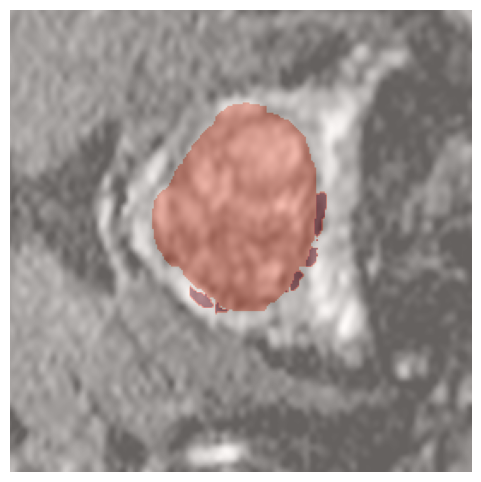

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# image: HxW (grayscale) or HxWx3 (RGB)
# mask:  HxW (binary or label mask)

plt.figure(figsize=(6, 6))

plt.imshow(adc[:,:,15], cmap="gray")
plt.imshow(seg[:,:,15], cmap="Reds", alpha=0.4)  # overlay mask
plt.axis("off")

plt.show()

In [5]:
args.num_classes = 4
args.mil_mode = "att_trans"
args.use_heatmap = True
args.tile_size = 64
args.tile_count = 24
args.depth = 3


In [6]:
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


pirads_model = MILModel_3D(
    num_classes=args.num_classes,  
    mil_mode=args.mil_mode 
)
pirads_checkpoint = torch.load(os.path.join(args.project_dir, 'models', 'pirads.pt'), map_location="cpu")
pirads_model.load_state_dict(pirads_checkpoint["state_dict"])
pirads_model.to(args.device)

cspca_model = csPCa_Model(backbone=pirads_model).to(args.device)
checkpt = torch.load(os.path.join(args.project_dir, 'models', 'cspca_model.pth'), map_location="cpu")
cspca_model.load_state_dict(checkpt['state_dict'])
cspca_model = cspca_model.to(args.device)

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related t

In [7]:
transform = data_transform(args)
files = os.listdir(args.t2_dir)
data_list = []
for file in files:
    temp = {}
    temp['image'] = os.path.join(args.t2_dir, file)
    temp['dwi'] = os.path.join(args.dwi_dir, file)
    temp['adc'] = os.path.join(args.adc_dir, file)
    temp['heatmap'] = os.path.join(args.heatmapdir, file)
    temp['mask'] = os.path.join(args.seg_dir, file)
    temp['label'] = 0  # dummy label
    data_list.append(temp)

dataset = Dataset(data=data_list, transform=transform)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    multiprocessing_context= None,
    sampler=None,
    collate_fn=list_data_collate,
)

In [8]:
pirads_list = []
pirads_model.eval()
cspca_risk_list = []
cspca_model.eval()
top5_patches = []
with torch.no_grad():
    for idx, batch_data in enumerate(loader):
        data = batch_data["image"].as_subclass(torch.Tensor).to(args.device)
        logits = pirads_model(data)
        pirads_score= torch.argmax(logits, dim=1)
        pirads_list.append(pirads_score.item())

        output = cspca_model(data)
        output = output.squeeze(1)
        cspca_risk_list.append(output.item())

        sh = data.shape
        x = data.reshape(sh[0] * sh[1], sh[2], sh[3], sh[4], sh[5])
        x = cspca_model.backbone.net(x)
        x = x.reshape(sh[0], sh[1], -1)
        x = x.permute(1, 0, 2)
        x = cspca_model.backbone.transformer(x)
        x = x.permute(1, 0, 2)
        a = cspca_model.backbone.attention(x)
        a = torch.softmax(a, dim=1)
        a = a.view(-1)
        top5_values, top5_indices = torch.topk(a, 5)

        patches_top_5 = []
        for i in range(5):
            patch_temp = data[0, top5_indices.cpu().numpy()[i]][0].cpu().numpy()
            patches_top_5.append(patch_temp)

In [9]:
type(patches_top_5)

list

In [11]:
import argparse
import os
import shutil
import time
import yaml
import sys
import gdown
import numpy as np
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from monai.config import KeysCollection
from monai.metrics import Cumulative, CumulativeAverage
from monai.networks.nets import milmodel, resnet, MILModel
from monai.transforms import (
    Compose,
    GridPatchd,
    LoadImaged,
    MapTransform,
    RandFlipd,
    RandGridPatchd,
    RandRotate90d,
    ScaleIntensityRanged,
    SplitDimd,
    ToTensord,
    ConcatItemsd, 
    SelectItemsd,
    EnsureChannelFirstd,
    RepeatChanneld,
    DeleteItemsd,
    EnsureTyped,
    ClipIntensityPercentilesd,
    MaskIntensityd,
    HistogramNormalized,
    RandBiasFieldd,
    RandCropByPosNegLabeld,
    NormalizeIntensityd,
    SqueezeDimd,
    CropForegroundd,
    ScaleIntensityd,
    SpatialPadd,
    CenterSpatialCropd,
    ScaleIntensityd,
    Transposed,
    RandWeightedCropd,
)
from sklearn.metrics import cohen_kappa_score
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data.dataloader import default_collate
from torchvision.models.resnet import ResNet50_Weights
from src.data.custom_transforms import ClipMaskIntensityPercentilesd, NormalizeIntensity_customd
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import wandb
import math
from monai.data import Dataset, load_decathlon_datalist, ITKReader, NumpyReader, PersistentDataset

from src.model.MIL import MILModel_3D
from src.model.csPCa_model import csPCa_Model

import logging
from pathlib import Path

In [13]:
transform_image = Compose(
    [
        LoadImaged(keys=["image", "mask"], reader=ITKReader(), ensure_channel_first=True, dtype=np.float32),
        ClipMaskIntensityPercentilesd(keys=["image"], lower=0, upper=99.5, mask_key="mask"),
        NormalizeIntensity_customd(keys=["image"], mask_key="mask", channel_wise=True),
        EnsureTyped(keys=["label"], dtype=torch.float32),
        ToTensord(keys=["image", "label"]),
    ]
)
dataset_image = Dataset(data=data_list, transform=transform_image)


In [19]:
dataset_image[0]['image'][0].numpy().shape

(270, 270, 28)

In [20]:
data_list

[{'image': '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/processed/t2_histmatched/1009449_11049598.nrrd',
  'dwi': '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/processed/DWI_histmatched/1009449_11049598.nrrd',
  'adc': '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/processed/ADC_histmatched/1009449_11049598.nrrd',
  'heatmap': '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/processed/heatmaps/1009449_11049598.nrrd',
  'mask': '/sc-scratch/sc-scratch-cc06-ag-ki-radiologie/prostate_foundation/WSAttention-Prostate/datatemp/processed/prostate_mask/1009449_11049598.nrrd',
  'label': 0}]